In [3]:
import cv2
import numpy as np
import os
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from pyefd import elliptic_fourier_descriptors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

In [4]:
%matplotlib inline

In [11]:
# All Requirdef read_images_and_extract_contours_single_image(img_location):

def read_images_and_extract_contours_single_image(img_location):
    """Read images from a folder and extract their largest external contour."""
    images = img_location
    contours_list = []
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            contour = max(contours, key=cv2.contourArea)
            contour = contour.squeeze()
            contours_list.append(normalize_contour_points(contour))
    return contours_list

# def compute_fourier_coefficients(contour, order=10):
#     """Compute the Fourier coefficients of a contour."""
#     coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
#     return coeffs

def normalize_contour_points(contour):
    """Normalize contour points to a fixed number for consistency."""
    N = 250
    contour_length = np.linspace(0, 1, len(contour))
    normalized_length = np.linspace(0, 1, N)
    interp_func_x = interp1d(contour_length, contour[:, 0], kind='linear')
    interp_func_y = interp1d(contour_length, contour[:, 1], kind='linear')
    normalized_contour = np.vstack((interp_func_x(normalized_length), interp_func_y(normalized_length))).T
    return normalized_contour

def compute_first_10_harmonics(contour, order=30):
    """Compute Fourier coefficients and return the first 10 harmonics."""
    coeffs = elliptic_fourier_descriptors(contour, order=order, normalize=True)
    first_10_harmonics = coeffs[:10]  # Extract the first 10 harmonics
    return first_10_harmonics

def show_image(image_path):
    """Display an image."""
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error loading image: {image_path}")
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(rgb_image)
    plt.title(image_path)
    plt.axis('off')
    plt.show()

def plot_harmonic_distribution(harmonics):
    """Plot the distribution of the first 10 harmonic or coefficients as magnitudes."""
    # Compute magnitudes for each harmonic (A_n, B_n, C_n, D_n)
    magnitudes = np.linalg.norm(harmonics, axis=1)  # Calculate sqrt(A_n^2 + B_n^2 + C_n^2 + D_n^2)
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    harmonic_indices = np.arange(1, len(magnitudes) + 1)
    plt.bar(harmonic_indices, magnitudes, color='skyblue', alpha=0.7)

    # Add labels and title
    plt.xlabel('Harmonic Number')
    plt.ylabel('Magnitude')
    plt.title('Distribution of the First 10 Harmonics')
    plt.xticks(harmonic_indices)

    # Show the plot
    plt.show()

def calculate_separator(efd_coeffs, m=3):
    # Extract the first 10 harmonics
    first_10_harmonics = efd_coeffs[:10]
    print(first_10_harmonics.shape)
    print(first_10_harmonics)

    # Calculate the separator value
    # separator_value = np.sum(first_10_harmonics * np.power(np.arange(10), m))
    separator_value = np.sum(first_10_harmonics * np.power(np.arange(10), m).reshape(10, 1))

    return separator_value


# Test Case 1

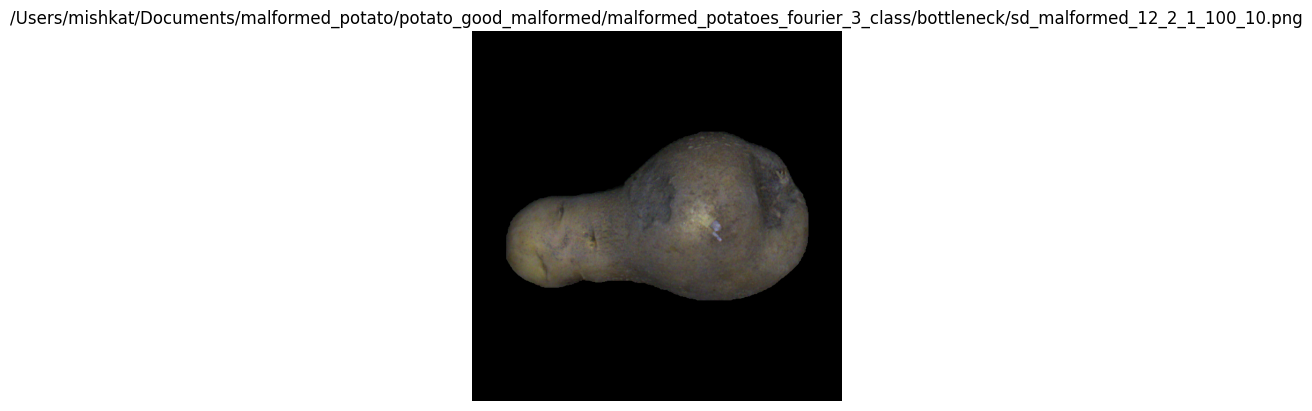

In [126]:
case_1 = '/Users/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/bottleneck/sd_malformed_12_2_1_100_10.png'

show_image(case_1)

In [127]:
contours_case_1 = read_images_and_extract_contours_single_image([case_1])[0]

In [128]:
first_10_harmonics_case_1 = compute_first_10_harmonics(contours_case_1)

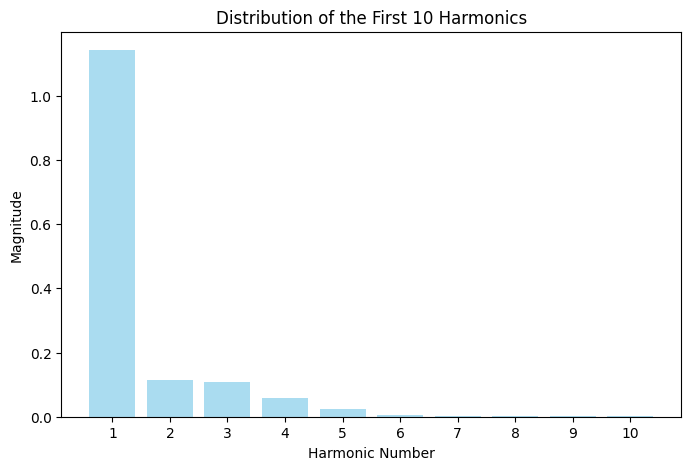

In [129]:
plot_harmonic_distribution(first_10_harmonics_case_1)

In [130]:
def calculate_separator_old(efd_coeffs):
    # Extract the first 10 harmonics
    first_10_harmonics = efd_coeffs[:10]
    print(first_10_harmonics.shape)
    print(first_10_harmonics)

    # Calculate the separator value
    separator_value = np.sum(first_10_harmonics * np.abs(first_10_harmonics)**3)

    return separator_value

In [131]:
calculate_separator_old(first_10_harmonics_case_1)

(10, 4)
[[ 1.00000000e+00 -4.11296311e-17  1.70617358e-17 -5.52570366e-01]
 [-3.04092695e-02 -1.25999907e-02  9.03849476e-03 -1.10595575e-01]
 [ 7.66517071e-02 -2.60998114e-03  9.42163156e-03 -7.45592650e-02]
 [-2.14113272e-02 -4.53565409e-03 -3.61919070e-03  5.28690922e-02]
 [ 4.28531425e-03 -3.93233364e-03 -5.43061607e-03 -2.29199843e-02]
 [-3.70395780e-03 -2.92326755e-03  5.96738218e-04  1.37181307e-03]
 [ 2.13312419e-03  3.81513513e-04 -4.18341631e-04  2.87394028e-05]
 [-2.83015391e-03 -2.18417497e-03 -8.93119451e-04  3.41578745e-04]
 [-1.14931600e-03 -6.67447090e-04  2.04174595e-03  1.25733688e-03]
 [ 1.04653645e-03 -7.79432381e-04 -3.20947634e-04  2.12935346e-04]]


0.9066316131952632

In [132]:
calculate_separator(first_10_harmonics_case_1, m=3)

(10, 4)
[[ 1.00000000e+00 -4.11296311e-17  1.70617358e-17 -5.52570366e-01]
 [-3.04092695e-02 -1.25999907e-02  9.03849476e-03 -1.10595575e-01]
 [ 7.66517071e-02 -2.60998114e-03  9.42163156e-03 -7.45592650e-02]
 [-2.14113272e-02 -4.53565409e-03 -3.61919070e-03  5.28690922e-02]
 [ 4.28531425e-03 -3.93233364e-03 -5.43061607e-03 -2.29199843e-02]
 [-3.70395780e-03 -2.92326755e-03  5.96738218e-04  1.37181307e-03]
 [ 2.13312419e-03  3.81513513e-04 -4.18341631e-04  2.87394028e-05]
 [-2.83015391e-03 -2.18417497e-03 -8.93119451e-04  3.41578745e-04]
 [-1.14931600e-03 -6.67447090e-04  2.04174595e-03  1.25733688e-03]
 [ 1.04653645e-03 -7.79432381e-04 -3.20947634e-04  2.12935346e-04]]


-2.3934966628765006

In [133]:
def calculate_separator_old_modified(efd_coeffs, m=3):
    # Extract the first 10 harmonics
    first_10_harmonics = efd_coeffs[:10]

    # Calculate the separator value
    separator_value = np.sum(first_10_harmonics * np.power(np.arange(10), m).reshape(10, 1))

    return separator_value

In [134]:
calculate_separator_old_modified(first_10_harmonics_case_1, m=3)

-2.3934966628765006

In [135]:

# def compute_S(harmonics, m):
#     """
#     Compute the separator S by multiplying each harmonic by h^m 
#     and summing the values over the first 10 harmonics.
    
#     harmonics: array of Fourier coefficients (first 10 harmonics)
#     m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3)
#     """
#     S = 0
#     for h in range(1, 11):  # Assuming h starts from 1 to 10
#         S += harmonics[h - 1] * (h ** m)
#     return S


In [136]:
compute_S(first_10_harmonics, m=3)

18.749971209900316

In [137]:
import numpy as np

def compute_S_single(harmonics, m):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(1, 11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        # Compute the magnitude of the harmonic
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S


In [138]:
compute_S(first_10_harmonics_case_1, m=3)

18.749971209900316

In [22]:
# import numpy as np

def compute_S(harmonics, m):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        # Compute the magnitude of the harmonic
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S


In [139]:
calculate_separator_granular(first_10_harmonics_case_1, m=3)

Magnitudes: 
 [1.14251215 0.1157435  0.10737852 0.0573346  0.024262   0.00495003
 0.00220717 0.00370064 0.00274154 0.00136055]
Weights: 
 [  0   1   8  27  64 125 216 343 512 729]
Weighted Magnitudes: 
 [0.         0.1157435  0.85902819 1.54803424 1.55276773 0.61875333
 0.47674909 1.26931922 1.40366791 0.99184254]


8.835905753901894

# Test case 2 (Good Potoato)

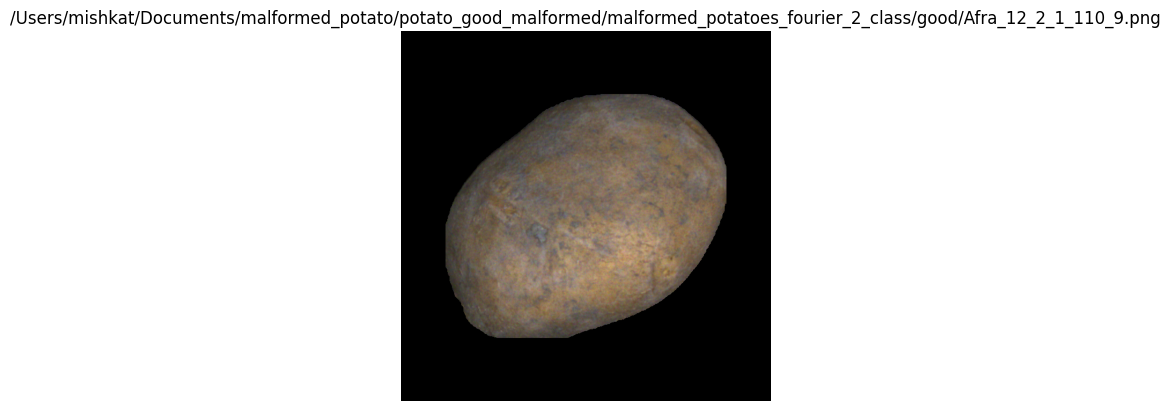

In [140]:
case_2 = '/Users/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_2_class/good/Afra_12_2_1_110_9.png'

show_image(case_2)

In [141]:
contours_case_2 = read_images_and_extract_contours_single_image([case_2])[0]

In [147]:
first_10_harmonics_case_2 = compute_first_10_harmonics(contours_case_2)

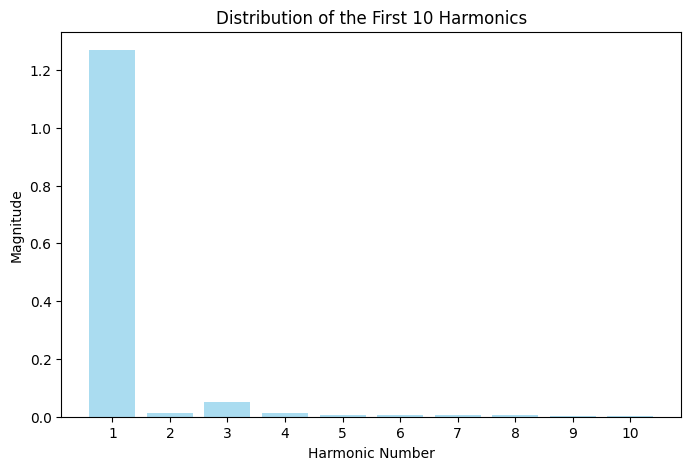

In [148]:
plot_harmonic_distribution(first_10_harmonics_case_2)

In [149]:
compute_S(first_10_harmonics_case_2, m=3)

15.409488671540762

In [150]:
def calculate_separator_with_magnitude_in_mind(efd_coeffs, m=3):
    # Extract the first 10 harmonics
    first_10_harmonics = efd_coeffs[:10]

    # Calculate the magnitudes
    magnitudes = np.linalg.norm(first_10_harmonics, axis=1)
    print(magnitudes)

    # Calculate the separator value
    separator_value = np.sum(magnitudes * np.power(np.arange(10), m))

    return separator_value

In [151]:
calculate_separator_with_magnitude_in_mind(first_10_harmonics_case_2, m=3)

[1.26870422 0.01393343 0.04955045 0.01180811 0.00717104 0.00763634
 0.00480736 0.00470615 0.00292749 0.00319729]


8.624945832371901

In [6]:
def calculate_separator_granular(efd_coeffs, m=3):
    # Extract the first 10 harmonics
    first_10_harmonics = efd_coeffs[:10]

    # Calculate the magnitudes
    magnitudes = np.linalg.norm(first_10_harmonics, axis=1)
    print("Magnitudes: \n", magnitudes)

    # Calculate the weights
    weights = np.power(np.arange(10), m)
    print("Weights: \n", weights)

    # Multiply magnitudes and weights
    weighted_magnitudes = magnitudes * weights
    print("Weighted Magnitudes: \n", weighted_magnitudes)

    # Calculate the separator value
    separator_value = np.sum(weighted_magnitudes)

    return separator_value

In [152]:
calculate_separator_granular(first_10_harmonics_case_2, m=3)

Magnitudes: 
 [1.26870422 0.01393343 0.04955045 0.01180811 0.00717104 0.00763634
 0.00480736 0.00470615 0.00292749 0.00319729]
Weights: 
 [  0   1   8  27  64 125 216 343 512 729]
Weighted Magnitudes: 
 [0.         0.01393343 0.39640357 0.31881902 0.45894667 0.95454215
 1.03838876 1.61420905 1.49887733 2.33082586]


8.624945832371901

In [162]:
calculate_separator_old(first_10_harmonics_case_2)

(10, 4)
[[ 1.00000000e+00  9.65913524e-18  3.96577374e-17 -7.80775510e-01]
 [-4.68708947e-03 -2.92499899e-03  5.86216466e-03 -1.13688604e-02]
 [ 3.56792295e-02  2.85336281e-03 -7.05096528e-03 -3.35317991e-02]
 [ 1.98508368e-04 -6.11164358e-03  6.35957985e-03  7.84828995e-03]
 [ 1.68890181e-03  5.64581781e-03 -1.72279610e-03 -3.70515372e-03]
 [ 4.42497101e-04 -5.02131162e-03 -1.85678904e-03 -5.42739406e-03]
 [-2.03871147e-03  2.52121812e-03  2.59398035e-03 -2.42261144e-03]
 [ 4.81748030e-04 -2.95837879e-03  2.96365050e-04  3.61606395e-03]
 [-2.28321793e-03 -2.11708093e-04  1.58081702e-03  9.01852979e-04]
 [ 2.05484466e-03 -8.10655893e-04 -2.27952279e-03 -3.83278482e-04]]


0.628375504662831

In [163]:
calculate_separator(first_10_harmonics_case_2, m=3)

(10, 4)
[[ 1.00000000e+00  9.65913524e-18  3.96577374e-17 -7.80775510e-01]
 [-4.68708947e-03 -2.92499899e-03  5.86216466e-03 -1.13688604e-02]
 [ 3.56792295e-02  2.85336281e-03 -7.05096528e-03 -3.35317991e-02]
 [ 1.98508368e-04 -6.11164358e-03  6.35957985e-03  7.84828995e-03]
 [ 1.68890181e-03  5.64581781e-03 -1.72279610e-03 -3.70515372e-03]
 [ 4.42497101e-04 -5.02131162e-03 -1.85678904e-03 -5.42739406e-03]
 [-2.03871147e-03  2.52121812e-03  2.59398035e-03 -2.42261144e-03]
 [ 4.81748030e-04 -2.95837879e-03  2.96365050e-04  3.61606395e-03]
 [-2.28321793e-03 -2.11708093e-04  1.58081702e-03  9.01852979e-04]
 [ 2.05484466e-03 -8.10655893e-04 -2.27952279e-03 -3.83278482e-04]]


-1.573131445093723

# Case 3 Ginger

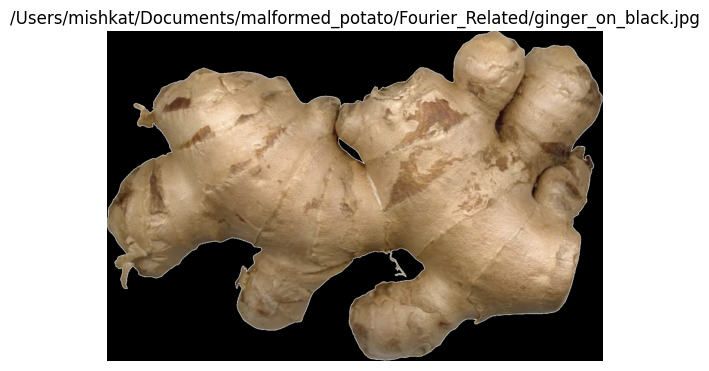

In [19]:
# case_3 = '/Users/mishkat/Documents/malformed_potato/ginger-thinkstockphotos-531052216-square.jpg'
case_3 = '/Users/mishkat/Documents/malformed_potato/Fourier_Related/ginger_on_black.jpg'

show_image(case_3)

In [12]:
contours_case_3 = read_images_and_extract_contours_single_image([case_3])[0]

In [13]:
first_10_harmonics_case_3 = compute_first_10_harmonics(contours_case_3)

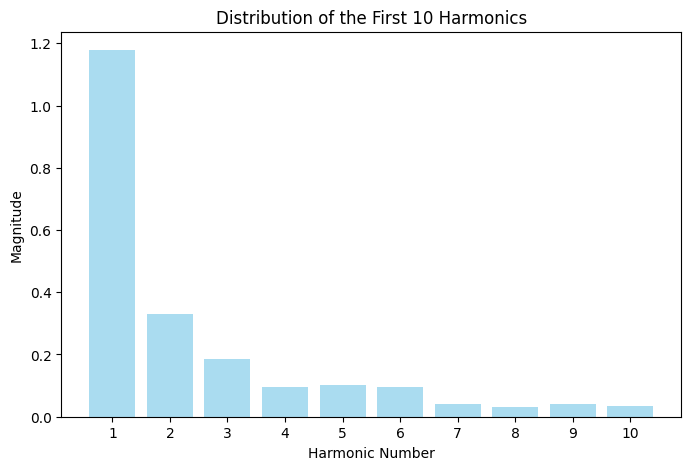

In [14]:
plot_harmonic_distribution(first_10_harmonics_case_3)

In [15]:
calculate_separator(first_10_harmonics_case_3, m=3)

(10, 4)
[[ 1.00000000e+00  4.62826564e-17  3.89659502e-19 -6.23277155e-01]
 [-8.22166442e-04  2.69123456e-01  1.43827220e-01 -1.21876909e-01]
 [ 8.06662680e-02  5.06548399e-02 -1.18739805e-02 -1.57032937e-01]
 [ 6.28160976e-02 -6.81730267e-03  3.65049788e-02 -6.22888908e-02]
 [ 1.69597277e-02 -5.65960737e-02 -2.77956886e-02  7.77400457e-02]
 [-8.35963524e-02 -2.05656727e-02  4.21133685e-02  7.18113000e-03]
 [ 1.38740478e-02  5.11049271e-03 -2.86176764e-02 -2.76477193e-02]
 [-1.49254492e-02 -2.14208675e-03  2.59404209e-02  1.12442331e-02]
 [ 1.97206625e-02 -1.41863276e-02 -1.01942816e-02 -3.02028856e-02]
 [ 2.30148744e-02 -1.36621980e-02 -1.95256367e-02 -1.19441016e-02]]


-40.51896260206432

In [158]:
calculate_separator_old(first_10_harmonics_case_3)

(10, 4)
[[ 1.00000000e+00  3.18008120e-17  8.67413051e-17 -9.99197426e-01]
 [-6.11698665e-04 -1.60184839e-04 -6.90227543e-05 -9.69372936e-05]
 [-5.98983712e-02 -9.27301313e-02  9.30747179e-02 -6.02546509e-02]
 [ 1.86242384e-04 -1.28531817e-04  1.77492575e-04 -1.40277132e-04]
 [-2.18468418e-02 -3.38586470e-02 -3.36372755e-02  2.17556728e-02]
 [-4.54541537e-05  2.08391458e-04 -2.02313802e-08  8.54189456e-05]
 [-8.29022307e-03  1.84363406e-02 -1.84993468e-02 -8.31856772e-03]
 [-3.27031023e-05 -7.33007464e-06 -8.95343649e-05 -9.83991842e-05]
 [-5.11303894e-03  1.13475487e-02  1.12445095e-02  5.05204029e-03]
 [ 8.20577218e-05 -9.41496384e-05  6.84697954e-07  1.40581237e-05]]


0.003178909280044331

In [159]:
calculate_separator_old_modified(first_10_harmonics_case_3, m=3)

2.607160095760138

In [16]:
calculate_separator_granular(first_10_harmonics_case_3, m=3)

Magnitudes: 
 [1.17833544 0.32858539 0.18404699 0.09594195 0.10152272 0.0961062
 0.04244967 0.03204209 0.0400786  0.03521721]
Weights: 
 [  0   1   8  27  64 125 216 343 512 729]
Weighted Magnitudes: 
 [ 0.          0.32858539  1.47237591  2.59043256  6.49745416 12.01327486
  9.1691278  10.99043823 20.52024268 25.67334888]


89.25528048035036

In [186]:
compute_S(first_10_harmonics_case_3, m=3)

30.949796061811025

In [164]:
# import numpy as np

def compute_S_only_positive(harmonics, m, epsilon=1e-10):
    """
    Compute the separator S by multiplying the magnitude of each harmonic by h^m 
    and summing the values over the first 10 harmonics.
    
    harmonics: array of Fourier coefficients (first 10 harmonics), 
               where each harmonic has 4 components (A, B, C, D).
    m: the power to which the harmonic index h is raised (e.g., 1, 2, or 3).
    epsilon: a small constant to ensure positive magnitudes (default: 1e-10).
    
    Returns a single scalar value for S.
    """
    S = 0
    for h in range(1, 11):  # Loop over the first 10 harmonics (h starts from 1 to 10)
        # Get the Fourier coefficients (A, B, C, D) for the h-th harmonic
        A, B, C, D = harmonics[h - 1]
        
        # Compute the magnitude of the harmonic, ensuring it's positive
        magnitude = np.sqrt(A**2 + B**2 + C**2 + D**2)
        
        # Ensure the magnitude is positive by adding a small epsilon if needed
        magnitude = np.abs(magnitude) + epsilon
        
        # Compute the contribution to S (magnitude * h^m)
        S += magnitude * (h ** m)
        
    return S


In [165]:
compute_S_only_positive(first_10_harmonics_case_3, m=3)

35.60451943340817

In [166]:
# Calculate Separator suggestion

def calculate_separator_suggested_change(efd_coeffs, m=3):
    # Extract the first 10 harmonics (assuming 4 coefficients per harmonic)
    first_10_harmonics = efd_coeffs[:10]

    # Calculate magnitudes for each harmonic (A, B, C, D)
    magnitudes = np.sqrt(np.sum(np.square(first_10_harmonics), axis=1))  # Compute magnitude for each harmonic

    # Generate harmonic indices, starting from 1 to 10
    harmonic_indices = np.arange(1, 11)

    # Calculate the separator value (sum of weighted magnitudes)
    separator_value = np.sum(magnitudes * np.power(harmonic_indices, m))

    return separator_value


In [167]:
calculate_separator_suggested_change(first_10_harmonics_case_1, m=3)

18.749971209900316

In [168]:
calculate_separator_suggested_change(first_10_harmonics_case_2, m=3)

15.409488671540762

In [169]:
calculate_separator_suggested_change(first_10_harmonics_case_3, m=3)

35.60451913090817

# Case 4

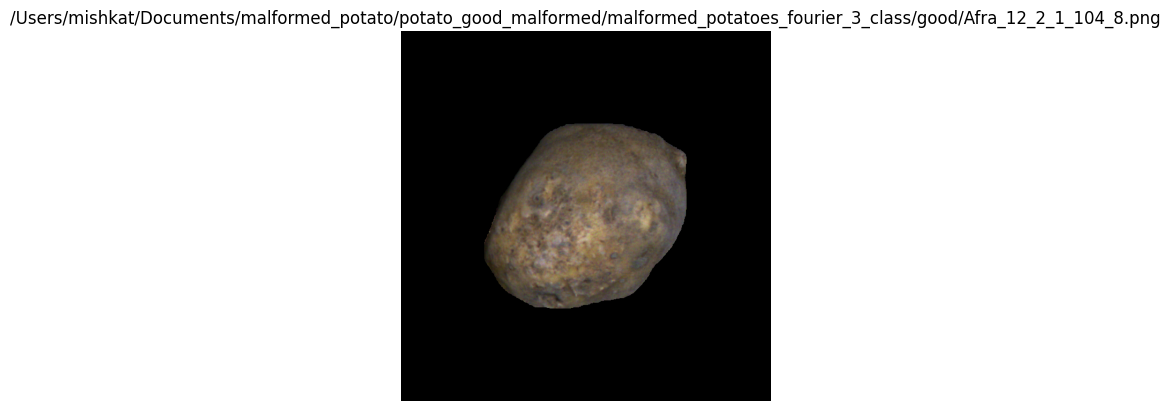

In [170]:
case_4 = '/Users/mishkat/Documents/malformed_potato/potato_good_malformed/malformed_potatoes_fourier_3_class/good/Afra_12_2_1_104_8.png'

show_image(case_4)

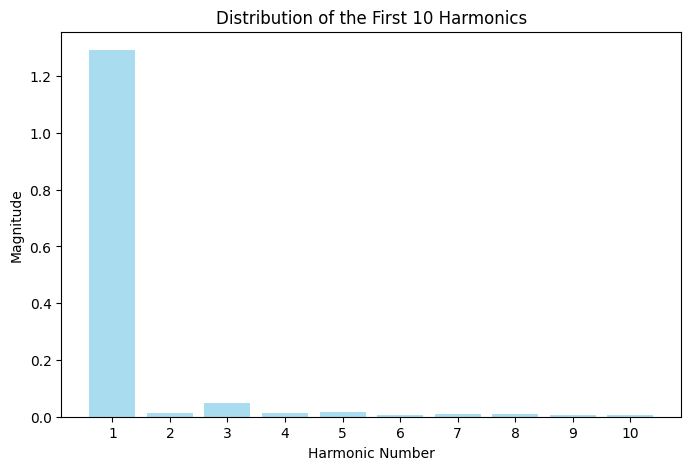

In [171]:
contour_case_4 = read_images_and_extract_contours_single_image([case_4])[0]

first_10_harmonics_case_4 = compute_first_10_harmonics(contour_case_4)

plot_harmonic_distribution(first_10_harmonics_case_4)

In [172]:
calculate_separator_suggested_change(first_10_harmonics_case_4, m=3)    

24.643948624800874

In [173]:
calculate_separator_granular(first_10_harmonics_case_4, m=3)

Magnitudes: 
 [1.29221258 0.01185841 0.04746918 0.01477552 0.01755373 0.00772513
 0.01002349 0.00802744 0.00668679 0.00474394]
Weights: 
 [  0   1   8  27  64 125 216 343 512 729]
Weighted Magnitudes: 
 [0.         0.01185841 0.3797534  0.39893899 1.12343882 0.96564098
 2.16507491 2.7534134  3.42363801 3.45833329]


14.680090231569359

In [174]:
compute_S(first_10_harmonics_case_4, m=3)

24.643948624800878

In [175]:
calculate_separator(first_10_harmonics_case_4, m=3)

(10, 4)
[[ 1.00000000e+00 -1.05501463e-16  6.55137178e-19 -8.18421253e-01]
 [-9.15903207e-03 -1.75272336e-03  7.50768269e-04 -7.28686626e-03]
 [ 4.22011192e-02 -1.12932132e-02  1.56710557e-02 -9.96340801e-03]
 [ 1.08559882e-05 -1.36842722e-03 -1.62580898e-03  1.46219003e-02]
 [ 9.62171797e-03 -3.66920488e-03 -1.06196355e-02 -9.45073073e-03]
 [ 7.05112068e-03  1.11946512e-03 -1.41831238e-03  2.58737042e-03]
 [ 1.99917716e-03 -3.83567307e-03  9.02664799e-03 -5.30075565e-04]
 [ 4.56220249e-03 -1.51916613e-03  6.20988802e-03 -1.65999879e-03]
 [ 7.07693526e-04 -4.02519868e-03 -5.19967462e-03 -9.86676212e-04]
 [ 2.53651769e-03 -4.00580506e-03 -9.01595798e-05  1.28278221e-04]]


-1.0127167666617791

In [176]:
calculate_separator_old(first_10_harmonics_case_4)

(10, 4)
[[ 1.00000000e+00 -1.05501463e-16  6.55137178e-19 -8.18421253e-01]
 [-9.15903207e-03 -1.75272336e-03  7.50768269e-04 -7.28686626e-03]
 [ 4.22011192e-02 -1.12932132e-02  1.56710557e-02 -9.96340801e-03]
 [ 1.08559882e-05 -1.36842722e-03 -1.62580898e-03  1.46219003e-02]
 [ 9.62171797e-03 -3.66920488e-03 -1.06196355e-02 -9.45073073e-03]
 [ 7.05112068e-03  1.11946512e-03 -1.41831238e-03  2.58737042e-03]
 [ 1.99917716e-03 -3.83567307e-03  9.02664799e-03 -5.30075565e-04]
 [ 4.56220249e-03 -1.51916613e-03  6.20988802e-03 -1.65999879e-03]
 [ 7.07693526e-04 -4.02519868e-03 -5.19967462e-03 -9.86676212e-04]
 [ 2.53651769e-03 -4.00580506e-03 -9.01595798e-05  1.28278221e-04]]


0.551353318078429

In [20]:
# import cv2
# import matplotlib.pyplot as plt

def read_images_and_extract_contours_single_image(img_location):
    """Read images from a folder and extract their largest external contour."""
    images = img_location
    contours_list = []
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if contours:
            # Find the largest contour
            contour = max(contours, key=cv2.contourArea)
            contour = contour.squeeze()  # Remove unnecessary dimensions
            contours_list.append(normalize_contour_points(contour))
            # Visualize the contour on the original image
            visualize_contour(image, contour)
    return contours_list

def visualize_contour(image, contour):
    """Visualize the contour on the image using matplotlib."""
    # Convert image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image_rgb)
    
    # Plot the contour on the image
    plt.plot(contour[:, 0], contour[:, 1], color='red', linewidth=2)  # Red contour line
    
    plt.title("Extracted Contour")
    plt.axis('off')  # Hide axes
    plt.show()

def normalize_contour_points(contour):
    """Normalize contour points for visualization (optional)."""
    # This function could be useful for contour normalization
    # Example: Scaling or translating points to some standard size
    return contour


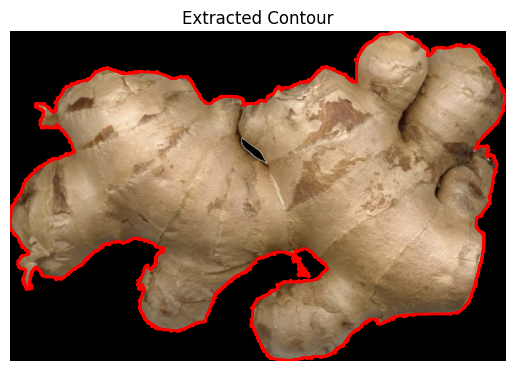

In [21]:
contours_view = read_images_and_extract_contours_single_image([case_3])[0]

In [1]:
import cv2
import numpy as np

# Step 1: Load the image
image = cv2.imread('/Users/mishkat/Documents/malformed_potato/Screenshot 2024-09-18 at 4.27.37 PM.png')

# Step 2: Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 3: Threshold the grayscale image to separate the background
# (255 means white, and the background is mostly white, so we set a high threshold)
_, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

# Invert the mask, so the ginger is white and the background is black
mask_inv = cv2.bitwise_not(mask)

# Step 4: Use bitwise operations to change the white background to black
# Create a black image of the same size
black_background = np.zeros_like(image)

# Copy the ginger onto the black background using the inverted mask
ginger_on_black = cv2.bitwise_and(image, image, mask=mask_inv)

# Step 5: Display the result
cv2.imshow('Ginger on Black Background', ginger_on_black)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Optionally, save the result
cv2.imwrite('ginger_on_black.jpg', ginger_on_black)


True

In [ ]:
compute_S()